In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from use_case.baseline import * 
from tests.eval import *

np.random.seed(1337)
torch.manual_seed(1337)

N = 10
payoff_i = np.random.uniform(-10, 10, (N, N))
payoff_j = np.random.uniform(-10, 10, (N, N))

# Initialize environment
N_ACTIONS = payoff_i.shape[0]
N_AGENTS = 500
env = BaselineEnvironment(N_AGENTS, payoff_i, payoff_j, total_games = 1)

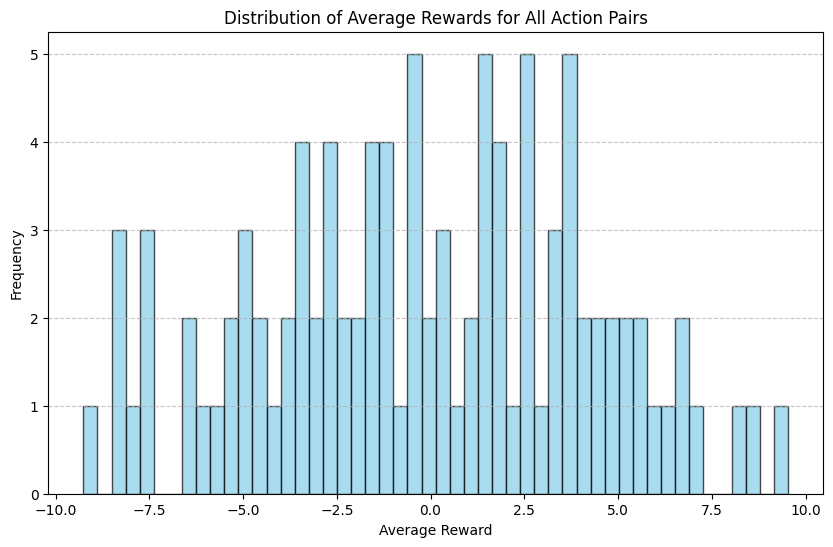

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt

# Calculate average rewards for all action pairs
average_rewards = (payoff_i + payoff_j) / 2

# Flatten the matrix into a list of all possible rewards
all_rewards = average_rewards.ravel()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_rewards, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Average Rewards for All Action Pairs')
plt.xlabel('Average Reward')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Actual Run

In [4]:
from models.model import *
from models.trainer import *

In [5]:
# Configure the network here
parameters = ParameterSettings(
    n_agents = N_AGENTS,
    d_action = N_ACTIONS, 
    d_obs = env.obs_size, 
    d_traits = 1,
    d_beliefs = 1,
    d_het_latent = 4
)
parameters.device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(parameters)

In [6]:
equilibriua = find_pure_equilibria(payoff_i, payoff_j)

for eq in equilibriua:
    x, y = eq 
    a = (y[0] + y[1]) / 2

    print(x, a)

(4, 9) 8.729602221265065
(5, 3) 9.52948118219827


In [7]:
evaluate_policy(model, env, 10)

np.float64(-0.5573725618506036)

In [ ]:
# Setup the training loop
training_parameters = TrainingParameters(
    outer_loops = 1_000,
    
    actor_learning_rate= 1e-4,
    critic_learning_rate = 1e-4,
    hypernet_learning_rate = 1e-4,

    hypernet_jsd_threshold = 1.0,

    sampled_agents_proportion = 1.0,
    experience_sampling_steps = 5,
    experience_buffer_size = 25,

    entropy_coeff = 0.2,

    epsilon_period = 0,
    
    should_train_hypernet = True,
    verbose = True
)


train_model(model, env, training_parameters)
        

  8%|▊         | 81/1000 [01:12<13:41,  1.12it/s]Exception in thread Thread-3:
Traceback (most recent call last):
  File "c:\Users\Joaquin\Desktop\Thesis-Playground\v3\models\trainer.py", line 338, in train_model
    evaluate_policy(model, env, writer=writer, global_step=params.global_steps)
  File "c:\Users\Joaquin\Desktop\Thesis-Playground\v3\tests\eval.py", line 122, in evaluate_policy

    writer.add_scalar(f'{header}/median_return', avg_return, global_step)
  File "c:\Users\Joaquin\miniconda3\envs\thesis2\Lib\site-packages\torch\utils\tensorboard\writer.py", line 381, in add_scalar
    self._get_file_writer().add_summary(summary, global_step, walltime)
  File "c:\Users\Joaquin\miniconda3\envs\thesis2\Lib\site-packages\torch\utils\tensorboard\writer.py", line 115, in add_summary
    self.add_event(event, global_step, walltime)
  File "c:\Users\Joaquin\miniconda3\envs\thesis2\Lib\site-packages\torch\utils\tensorboard\writer.py", line 99, in add_event
    self.event_writer.add_event(

FileNotFoundError: [Errno 2] No such file or directory: b'runs\\May12_15-35-12_LAPTOP-88AV9U3J\\events.out.tfevents.1747035312.LAPTOP-88AV9U3J.13392.0'

# Heterogeneous Baseline

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from use_case.baseline import * 
from tests.eval import *
from models.model import *
from models.trainer import *


In [ ]:
np.random.seed(1337)
torch.manual_seed(1337)

N_AGENTS = 2000 
N_TYPES = 10
N_ACTIONS = 10
type_payoffs = np.random.uniform(-10, 10, (N_TYPES, N_TYPES, 2, N_ACTIONS, N_ACTIONS))
env = BaselineHeterogeneous(N_AGENTS, N_TYPES, type_payoffs)

In [ ]:
# Configure the network here
parameters = ParameterSettings(
    n_agents = N_AGENTS,
    d_action = N_ACTIONS, 
    d_obs = env.obs_size, 
    d_traits = N_TYPES,
    d_beliefs = 1
    
)
parameters.device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(parameters)

In [ ]:
# Setup the training loop
training_parameters = TrainingParameters(
    outer_loops = 100,

    actor_learning_rate= 2.5e-4,
    critic_learning_rate = 1e-3,
    hypernet_learning_rate = 2.5e-4,

    hypernet_jsd_threshold = 0.25,

    sampled_agents = N_AGENTS // 4,
    experience_buffer_size = 10,

)


In [ ]:

train_model(model, env, training_parameters)